The aim in this notebook is to predict the total energy consumption in Germany. The main target timescale is to predict the consumption 15 minutes to 24 h in advance. 

First the needed modlues are imported. 

In [50]:
import pandas as pd
import numpy as np
import scipy as sp

import pmdarima as pm
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer

from datetime import date, time, datetime, timedelta

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

import pickle

#add fullr and co 
import statsmodels.tsa.stattools as smtime

#We mainly use xgboost
from xgboost import XGBRegressor
import xgboost as xgb

#some skitlearn tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

#trials
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import sklearn.metrics as met
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
#needs newest statsmodel 0.14.0 
from statsmodels.tsa.seasonal import MSTL

The data is obtained from https://www.smard.de/home/downloadcenter/download-marktdaten/?downloadAttributes=%7B%22selectedCategory%22:2,%22selectedSubCategory%22:false,%22selectedRegion%22:false,%22selectedFileType%22:false%7D
 using the categories Stromverbrauch then realisierter Stromverbrauch, then Deutschland, then the time intervall then viertelstunde.
                   
            
That the actual power consumption of Germany in the bets possible resolution of 15 minutes. To get all availble data (nearly 8 years) it is needed to download in four pieces. it gets 

In [51]:
#path to the data
path='/home/tobias/ml-testing/energy/'
#getting the data which is in four pieces
real_power1=pd.read_csv(path+"Realisierter_Stromverbrauch_202012010000_202211142359.csv",delimiter=';')
real_power4=pd.read_csv(path+"Realisierter_Stromverbrauch_201501010000_201611302359.csv",delimiter=';')
real_power3=pd.read_csv(path+"Realisierter_Stromverbrauch_201612010000_201811302359.csv",delimiter=';')
real_power2=pd.read_csv(path+"Realisierter_Stromverbrauch_201812010000_202011302359.csv",delimiter=';')

We are now printing the columns.

In [52]:
print(real_power1.columns)


Index(['Datum', 'Uhrzeit', 'Gesamt (Netzlast)[MWh]', 'Residuallast[MWh]',
       'Pumpspeicher[MWh]'],
      dtype='object')


They are in German, thus we rename them. Besides time and total power also resiudal power and pump storage could be useful.

In [53]:
#renaming columns
real_power1.rename(columns={'Datum':'Date','Uhrzeit':'Time','Gesamt (Netzlast)[MWh]':'total_power','Residuallast[MWh]':'residual_power','Pumpspeicher[MWh]':'pump_storage'},inplace=True)
real_power2.rename(columns={'Datum':'Date','Uhrzeit':'Time','Gesamt (Netzlast)[MWh]':'total_power','Residuallast[MWh]':'residual_power','Pumpspeicher[MWh]':'pump_storage'},inplace=True)
real_power3.rename(columns={'Datum':'Date','Uhrzeit':'Time','Gesamt (Netzlast)[MWh]':'total_power','Residuallast[MWh]':'residual_power','Pumpspeicher[MWh]':'pump_storage'},inplace=True)
real_power4.rename(columns={'Datum':'Date','Uhrzeit':'Time','Gesamt (Netzlast)[MWh]':'total_power','Residuallast[MWh]':'residual_power','Pumpspeicher[MWh]':'pump_storage'},inplace=True)

print(real_power1.columns)


Index(['Date', 'Time', 'total_power', 'residual_power', 'pump_storage'], dtype='object')


Now we create a true date time column combing the day and time column and applying datetime methods.

In [54]:
real_power1['date_time']=pd.to_datetime(real_power1['Date'] + '.' + real_power1['Time'], format='%d.%m.%Y.%H:%M')
real_power2['date_time']=pd.to_datetime(real_power2['Date'] + '.' + real_power2['Time'], format='%d.%m.%Y.%H:%M')
real_power3['date_time']=pd.to_datetime(real_power3['Date'] + '.' + real_power3['Time'], format='%d.%m.%Y.%H:%M')
real_power4['date_time']=pd.to_datetime(real_power4['Date'] + '.' + real_power4['Time'], format='%d.%m.%Y.%H:%M')
print(real_power1.columns)
print(real_power1.dtypes)

Index(['Date', 'Time', 'total_power', 'residual_power', 'pump_storage',
       'date_time'],
      dtype='object')
Date                      object
Time                      object
total_power              float64
residual_power           float64
pump_storage             float64
date_time         datetime64[ns]
dtype: object


I am now combining the four different data sets and show the data in a plot. 

dimensions of the data are (276000, 6)


Text(0, 0.5, 'total power [GW]')

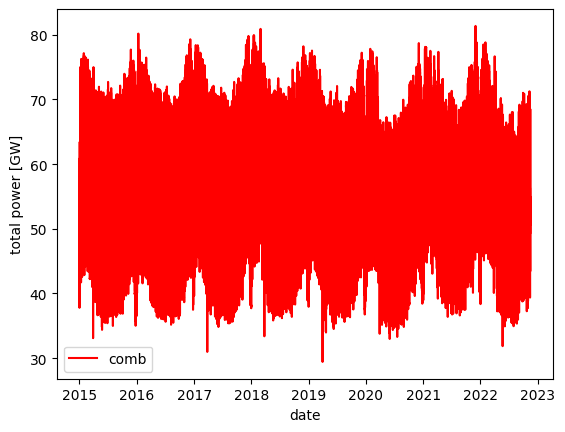

In [55]:
#date_time is set to index
real_power1=real_power1.set_index('date_time')
real_power2=real_power2.set_index('date_time')
real_power3=real_power3.set_index('date_time')
real_power4=real_power4.set_index('date_time')
#combing with concat
comb_real_power=pd.concat([real_power4,real_power3,real_power2,real_power1])
#rest index for easier handling
comb_real_power=comb_real_power.reset_index()
print(f"dimensions of the data are {comb_real_power.shape}")
plt.plot(comb_real_power['date_time'],comb_real_power['total_power']*4,'-',ms=1,color='red',label='comb') 
plt.legend(loc="best")
plt.xlabel("date")
plt.ylabel("total power [GW]")

Showing all makes it difficult to see more than some yearly varaiation and also that is supperimporsed on other vraiations. Therefore, I now zoom in a week. 

(18604.0, 18611.0)

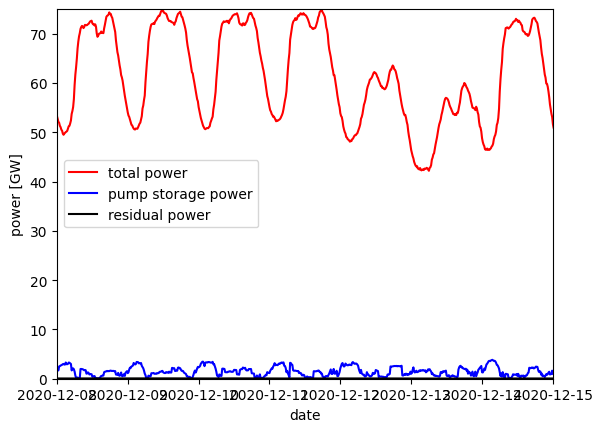

In [56]:
plt.plot(comb_real_power['date_time'],(comb_real_power['total_power']*4),'-',ms=1,color='red',label='total power') 
plt.plot(comb_real_power['date_time'],(comb_real_power['pump_storage']*4/1000),'-',ms=1,color='blue',label='pump storage power') 
plt.plot(comb_real_power['date_time'],(comb_real_power['residual_power']*4/1000),'-',ms=1,color='black',label='residual power') 
plt.legend(loc="best")
plt.xlabel("date")
plt.ylabel("power [GW]")
plt.ylim(0,75)
plt.xlim(datetime(2020, 12, 8),datetime(2020, 12, 15))

There are clear cycles in the data, the strongest on the day time scale. Below look again on a logarithmic scales to be able to see more for the other two properties. 

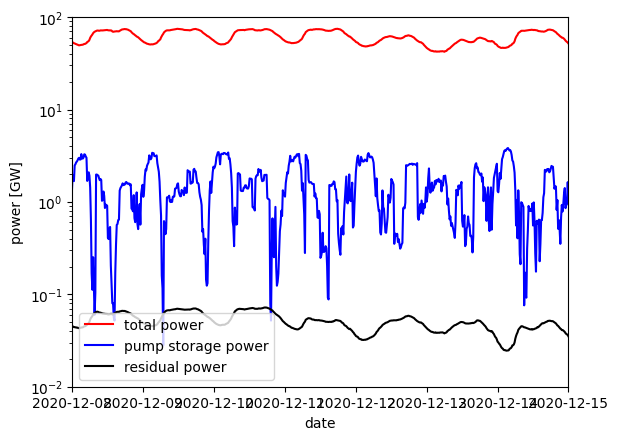

In [57]:
plt.plot(comb_real_power['date_time'],(comb_real_power['total_power']*4),'-',ms=1,color='red',label='total power') 
plt.plot(comb_real_power['date_time'],(comb_real_power['pump_storage']*4/1000),'-',ms=1,color='blue',label='pump storage power') 
plt.plot(comb_real_power['date_time'],(comb_real_power['residual_power']*4/1000),'-',ms=1,color='black',label='residual power') 
plt.legend(loc="best")
plt.xlabel("date")
plt.ylabel("power [GW]")
plt.ylim(0.01,100)
plt.xlim(datetime(2020, 12, 8),datetime(2020, 12, 15))
plt.yscale('log')


There is no clear connection of pump storage adn resodual power to total power and thus we ignore it for now.

As the next step we free space.

In [58]:
#free space 
#real_power1=0
real_power2=0
real_power3=0
real_power4=0

The dataset is clearly period, thus linear regression is not an option. It is also large making it important to choose efficient options. Random Forest was tried but is too slow to use for the full data set. Therefore XGBoost regressor was choosen. 

The two shorter periods are day and week. From the 15 minutes sampling follows:

In [59]:
print(f"steps per day: {int(24*60/15)}")
print(f"steps per week: {int(7*24*60/15)}")

steps per day: 96
steps per week: 672


Xgboost needs to have the data transformed into the usual supervised data structure. Therefore, I construct a function which uses some contonus data block to predict one future data point. There can be a gap between the data or now gap. 

In [60]:
def series_to_supervised(data, n_in=1, offset=0, dropnan=True):
    #n_vars = 1 if type(data) is list else data.shape[1] needs to excluded at ;least for single series
    #reate empty data frame and list
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t+offset)
    for i in range(offset, 1+offset):
        cols.append(df.shift(-i))
    # connecting all 
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

As test I first only the one data set and one day of data for predciying the next data point. 

In [67]:
power_2years=series_to_supervised(real_power1.total_power,96,0)
power_2years=pd.DataFrame(power_2years)

We use the last about 20% in test. 

In [73]:
steps = 13250
print(f"{round(steps/power_2years.shape[0]*100,2)} % in test")
data_train = power_2years.iloc[:-steps,:]
data_test  = power_2years.iloc[-steps:,:]
x_train=data_train.iloc[:,0:96]
x_test=data_test.iloc[:,0:96]
y_train=data_train.iloc[:,96]
y_test=data_test.iloc[:,96]

19.36 % in test


Now xgboost is used for fitting the data. 

In [74]:
xmodel1=XGBRegressor()
xmodel1.fit(x_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

And now to predict the future in test. We also create simple prediction which use data shiting by 15 minutes (the prediction time scale here), 1 day and 1 week. 

In [90]:
pred=xmodel1.predict(x_test)
#creates nan which ignored in the tests
shift_15min=y_test.shift(periods=1)
shift_1day=y_test.shift(periods=96)
shift_1week=y_test.shift(periods=672)

Below we compare the standard deviation scatter of this prediction with the shifted data.

In [85]:
print(f"standard deviation 15 minutes prediction {round(100*np.std(pred-y_test)/np.mean(y_test),2)} %")  
print(f"standard deviation 15 minutes shifted {round(100*np.std(shift_15min-y_test)/np.mean(y_test),2)} %")
print(f"standard deviation 1 day shifted {round(100*np.std(shift_1day-y_test)/np.mean(y_test),2)} %")
print(f"standard deviation 1 week shifted {round(100*np.std(shift_1week-y_test)/np.mean(y_test),2)} %")

standard deviation 15 minutes prediction 0.83 %
standard deviation 15 minutes shifted 1.27 %
standard deviation 1 day shifted 10.95 %
standard deviation 1 week shifted 5.6 %


There is an improve,ent co,matred to just shifting, the improvement is only small compared to 15 minutes shifts. It is larger for day and week time scale, whereby the week time scale performs better. 

Now I do prediction seperately for all time scale from 15 minutes to up to 1 day. This is done for both the 2 year data setand the 8 year data set. In both cases the same about 20 weeks are used for tested to avoid that the test period influences the result. Since the fitting takes time the result is saved and the fit is finished. 

In [ ]:
#fitting on about 1.5 yeras of data
resf=np.zeros((4,96))
steps = 13250
for i in range(resf.shape[1]):
    print(i)
    res3=series_to_supervised(real_power1.total_power,96,i)
    res3=pd.DataFrame(res3)
    dataa3_train = res3.iloc[:-steps,:]
    dataa3_test  = res3.iloc[-steps:,:]
    x3_train=dataa3_train.iloc[:,0:96]
    x3_test=dataa3_test.iloc[:,0:96]
    y3_train=dataa3_train.iloc[:,96]
    y3_test=dataa3_test.iloc[:,96]
    resf[0,i]=15*(i+1)
    xmodel3=XGBRegressor()
    xmodel3.fit(x3_train,y3_train)
    pred3=xmodel3.predict(x3_test)
    diff6=y3_test.shift(periods=i+1)
    resf[2,i]=np.std(pred3-y3_test)
    resf[1,i]=np.std(diff6-y3_test)
    resf[3,i]=np.mean(y3_test)
    #np.savetxt('xgb_1day_v1.txt',resf) 

In [28]:
#fiiting on about 7.5 years of data 
resf=np.zeros((4,96))
steps = 13250
for i in range(resf.shape[1]):
    print(i)
    res3=series_to_supervised(comb_real_power.total_power,96,i)
    res3=pd.DataFrame(res3)
    dataa3_train = res3.iloc[:-steps,:]
    dataa3_test  = res3.iloc[-steps:,:]
    x3_train=dataa3_train.iloc[:,0:96]
    x3_test=dataa3_test.iloc[:,0:96]
    y3_train=dataa3_train.iloc[:,96]
    y3_test=dataa3_test.iloc[:,96]
    resf[0,i]=15*(i+1)
    xmodel3=XGBRegressor()
    xmodel3.fit(x3_train,y3_train)
    pred3=xmodel3.predict(x3_test)
    diff6=y3_test.shift(periods=i+1)
    resf[2,i]=np.std(pred3-y3_test)
    resf[1,i]=np.std(diff6-y3_test)
    resf[3,i]=np.mean(y3_test)
    np.savetxt('xgb_1day_8yr_v1.txt',resf) 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95


The results form the two fits is then loaded again.  

In [91]:
pred_from_2years=np.loadtxt(path+'xgb_1day_v1.txt')
pred_from_8years=np.loadtxt(path+'xgb_1day_8yr_v1.txt')

In [ ]:
First, the prediction is compared using 2 and 8 years for fotting.

Text(0, 0.5, 'standard deviation (x-data)/data %')

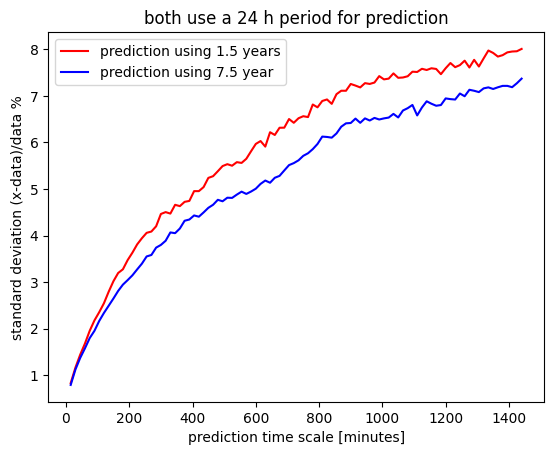

In [93]:
plt.plot(pred_from_2years[0],100*pred_from_2years[2]/pred_from_2years[3],'-',ms=1,color='red',label='prediction using 1.5 years') 
plt.plot(pred_from_8years[0],100*pred_from_8years[2]/pred_from_8years[3],'-',ms=1,color='blue',label='prediction using 7.5 year') 
plt.legend(loc="best")
plt.xlabel("prediction time scale [minutes]")
plt.title("both use a 24 h period for prediction")
plt.ylabel("standard deviation (x-data)/data %")


Using for data improves the prediction by up to 1%.

As another option to improve the fitting we now use 1 week of data since the scatter is smaller when this shift is used. 

In [94]:
resf=np.zeros((4,96))
#resf=np.loadtxt("xgb_1week_v1b.txt")
steps = 13250
for i in range(resf.shape[1]):
    print(i)
    res3=series_to_supervised(real_power1.total_power,672,i)
    res3=pd.DataFrame(res3)
    dataa3_train = res3.iloc[:-steps,:]
    dataa3_test  = res3.iloc[-steps:,:]
    x3_train=dataa3_train.iloc[:,0:672]
    x3_test=dataa3_test.iloc[:,0:672]
    y3_train=dataa3_train.iloc[:,672]
    y3_test=dataa3_test.iloc[:,672]
    resf[0,i]=15*(i+1)
    xmodel3=XGBRegressor()
    xmodel3.fit(x3_train,y3_train)
    pred3=xmodel3.predict(x3_test)
    diff6=y3_test.shift(periods=i+1)
    resf[2,i]=np.std(pred3-y3_test)
    resf[1,i]=np.std(diff6-y3_test)
    resf[3,i]=np.mean(y3_test)
    #np.savetxt('xgb_1week_v1b.txt',resf) protection this is not overwritten

0


I also tried that with the full 7.5 year data set. Howver, that did not work, likely because of limited RAM of my laptop. 

In [97]:
pred_from_2yearsweek=np.loadtxt(path+"xgb_1week_v1b.txt")



Text(0, 0.5, 'standard deviation (x-data)/data %')

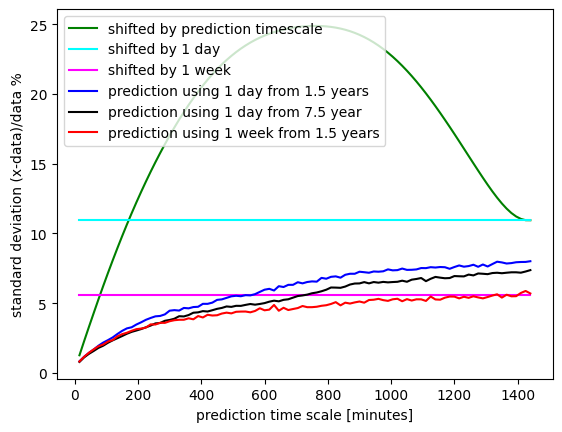

In [102]:
plt.plot(pred_from_2years[0],100*pred_from_2years[1]/pred_from_2years[3],'-',ms=1,color='green',label='shifted by prediction timescale') 
plt.plot(pred_from_2years[0],0*pred_from_2years[1]+100*np.std(shift_1day-y_test)/np.mean(y_test),'-',ms=1,color='cyan',label='shifted by 1 day')
plt.plot(pred_from_2years[0],0*pred_from_2years[1]+100*np.std(shift_1week-y_test)/np.mean(y_test),'-',ms=1,color='magenta',label='shifted by 1 week') 
plt.plot(pred_from_2years[0],100*pred_from_2years[2]/pred_from_2years[3],'-',ms=1,color='blue',label='prediction using 1 day from 1.5 years') 
plt.plot(pred_from_8years[0],100*pred_from_8years[2]/pred_from_8years[3],'-',ms=1,color='black',label='prediction using 1 day from 7.5 year') 
plt.plot(pred_from_2yearsweek[0],100*pred_from_2yearsweek[2]/pred_from_2years[3],'-',ms=1,color='red',label='prediction using 1 week from 1.5 years') 
plt.legend(loc="best")
plt.xlabel("prediction time scale [minutes]")
plt.ylabel("standard deviation (x-data)/data %")


It is visible that already at rather small time scales of 3 hours or less just using the last data point is not a good method. Using the dat from last week is rather good, it crosses the 1 day data prediction at about 10 h and is slightly better than the 1 week prediction for the full 24 hours. This betetr visible in the zoom plot below.  

Text(0, 0.5, 'standard deviation (x-data)/data %')

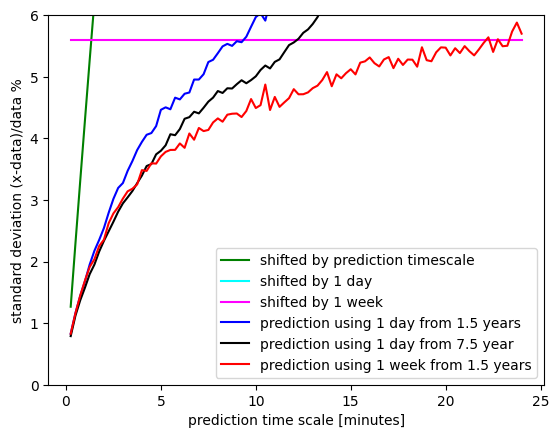

In [105]:
plt.plot(pred_from_2years[0]/60,100*pred_from_2years[1]/pred_from_2years[3],'-',ms=1,color='green',label='shifted by prediction timescale') 
plt.plot(pred_from_2years[0]/60,0*pred_from_2years[1]+100*np.std(shift_1day-y_test)/np.mean(y_test),'-',ms=1,color='cyan',label='shifted by 1 day')
plt.plot(pred_from_2years[0]/60,0*pred_from_2years[1]+100*np.std(shift_1week-y_test)/np.mean(y_test),'-',ms=1,color='magenta',label='shifted by 1 week') 
plt.plot(pred_from_2years[0]/60,100*pred_from_2years[2]/pred_from_2years[3],'-',ms=1,color='blue',label='prediction using 1 day from 1.5 years') 
plt.plot(pred_from_8years[0]/60,100*pred_from_8years[2]/pred_from_8years[3],'-',ms=1,color='black',label='prediction using 1 day from 7.5 year') 
plt.plot(pred_from_2yearsweek[0]/60,100*pred_from_2yearsweek[2]/pred_from_2years[3],'-',ms=1,color='red',label='prediction using 1 week from 1.5 years') 
plt.legend(loc="best")
plt.xlabel("prediction time scale [hours]")
plt.ylim(0,6)
plt.ylabel("standard deviation (x-data)/data %")

(0.0, 5.0)

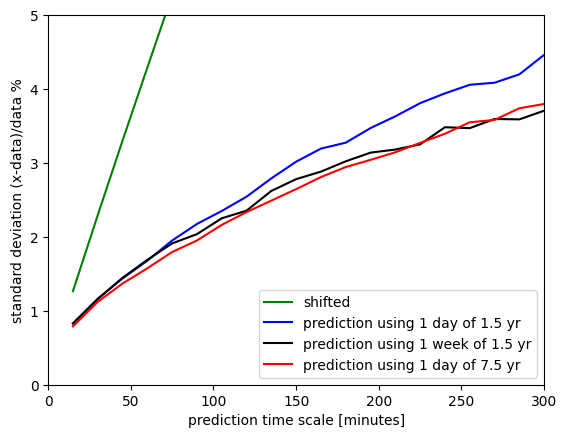

In [30]:
plt.plot(resf[0],100*resf[1]/resf[3],'-',ms=1,color='green',label='shifted') 
plt.plot(resf[0],100*resf[2]/resf[3],'-',ms=1,color='blue',label='prediction using 1 day of 1.5 yr') 
plt.plot(resf[0],100*resf2[2]/resf[3],'-',ms=1,color='black',label='prediction using 1 week of 1.5 yr') 
plt.plot(resf8[0],100*resf8[2]/resf8[3],'-',ms=1,color='red',label='prediction using 1 day of 7.5 yr')
plt.legend(loc="best")
plt.xlabel("prediction time scale [minutes]")
#plt.title("7 day random forest")
plt.ylabel("standard deviation (x-data)/data %")
plt.xlim(0,300)
plt.ylim(0,5)

The prediction which uses 1 day but uses about 7.5 year of data performs better than both other for time scales than about 4 hours but only by a rather small factor. Then the prediction using 1 week over 1.5 years is better which is about as good as shifting by a week  for 24 hours. That shows that the week time scale is important for large time scales, on small a preidction which relies on more recent data is also good. That is understandable since for small time scales weekday effect and not so important which are more important for larger time scales. 

I tried consecutive 15 minutes time scales, because that would be much faster than the several prediction used here. This preidction performs clearly much worse especially for longer time scales. 

Further, I tried to fit pd auto-arima but could not get to converge wirhin a lot. Likely, the fact that is data has multiple important period makes that function more difficult to use. 

To consider then several periods at once I now use Multiple Seasonal-Trend decomposition using LOESS (MSTL) which is included in the nwest version of statmodel.

In [44]:
#start
print(power.shape)
power_train = power.iloc[:-steps]
power_test  = power.iloc[-steps:]
print(power_train.shape)
ti3=np.arange(0,276000/24/4,1/24/4)
ti3_train = ti3[:-steps]
ti3_test  = ti3[-steps:]
print(ti3)

(276000,)
(262750,)
[0.00000000e+00 1.04166667e-02 2.08333333e-02 ... 2.87496875e+03
 2.87497917e+03 2.87498958e+03]


In [22]:
#needs box cor transformation if the differenctseasonality do not add linearly (enough) but is done automatically
#degree of interpolation 
#starts at about 11:50 to 12:49 but had wrong 'year' (quarter)
#again at 12:51
deg = {"seasonal_deg": 0} 
modelms = MSTL(power_train, periods=(24*4, 24 * 7*4,int(365.25*24*4)), stl_kwargs=deg)
#protect
#resms = modelms.fit()


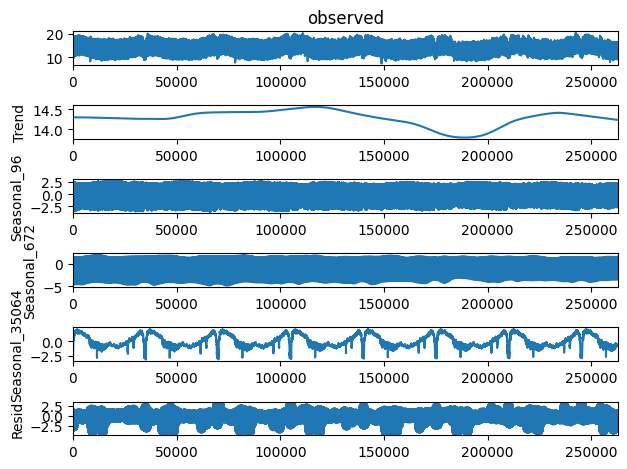

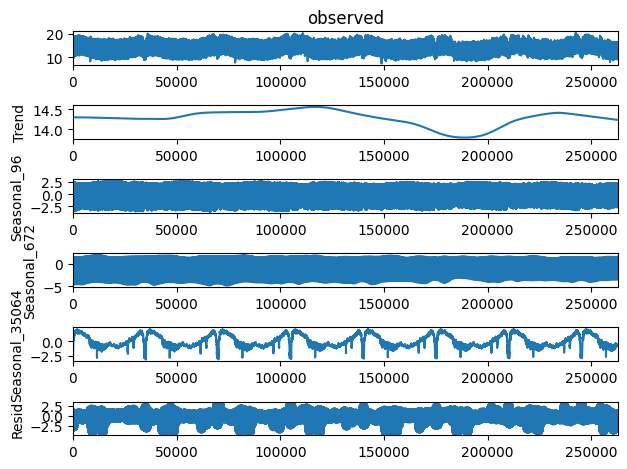

In [10]:
#with open('mstl_v1.pkl', 'wb') as pkl:
#    pickle.dump(resms, pkl)
with open('mstl_v1.pkl', 'rb') as f:
    # unpickle
    resms = pickle.load(f)
seasonal = resms.seasonal # contains 3 seasonal components
trend = resms.trend
residual = resms.resid
resms.plot()
#why double plot? 

In [11]:
#apply MSTL and then on top of it likely shorter term prediction works
print(np.std(residual)/np.mean(power_train)) #3.8% longterm goodness 
print(seasonal.shape)

NameError: name 'power_train' is not defined

In [ ]:
ti=np.arange(0,262750/24/4/365.25,1/24/4/365.25)
plt.plot(ti,trend,'-',ms=1,color='red',label='trend') 
plt.plot(ti,seasonal.iloc[:,2],'-',ms=1,color='blue',label='year signal') 
plt.legend(loc="best")
plt.xlabel("years")
plt.title("MTSL over 7.5 years")
plt.ylabel("total power [MW]")
#plt.xlim(0,1)

In [ ]:
ti2=np.arange(0,262750/24/4,1/24/4)
ti2b=np.arange(0,power.shape[0]/24/4,1/24/4)
plt.plot(ti2,power_train,'-',ms=1,color='black',label='observed') 
plt.plot(ti2,seasonal.iloc[:,0],'-',ms=1,color='blue',label='day signal') 
plt.plot(ti2,seasonal.iloc[:,1],'-',ms=1,color='red',label='week signal') 
plt.legend(loc="best")
plt.xlabel("days")
plt.title("MTSL over 7.5 years")
plt.ylabel("total power [MW]")
plt.xlim(7,14)

In [ ]:
plt.plot(ti2,power_train,'-',ms=1,color='black',label='observed') 
plt.plot(ti2,seasonal.iloc[:,0],'-',ms=1,color='blue',label='day signal') 
plt.plot(ti2,seasonal.iloc[:,1],'-',ms=1,color='red',label='week signal') 
plt.legend(loc="best")
plt.xlabel("days")
plt.title("MTSL over 7.5 years")
plt.ylabel("total power [MW]")
plt.xlim(190,197)

In [ ]:
plt.plot(ti2,power_train,'-',ms=1,color='red',label='observed') 
plt.plot(ti2,seasonal.iloc[:,0]+seasonal.iloc[:,1]+seasonal.iloc[:,2]+trend,'-',ms=1,color='blue',label='modelled') 
plt.legend(loc="best")
plt.xlabel("days")
plt.title("MTSL over 7.5 years")
plt.ylabel("total power [MW]")
plt.xlim(7,14)

In [12]:
plt.plot(ti2,power_train,'-',ms=1,color='red',label='observed') 
plt.plot(ti2,seasonal.iloc[:,0]+seasonal.iloc[:,1]+seasonal.iloc[:,2]+trend,'-',ms=1,color='blue',label='modelled') 
plt.legend(loc="best")
plt.xlabel("days")
plt.title("MTSL over 7.5 years")
plt.ylabel("total power [MW]")
plt.xlim(190,197)

NameError: name 'ti2' is not defined

In [13]:
plt.plot(ti2,power_train,'-',ms=1,color='red',label='observed') 
plt.plot(ti2,seasonal.iloc[:,0]+seasonal.iloc[:,1]+seasonal.iloc[:,2]+trend,'-',ms=1,color='blue',label='modelled') 
plt.legend(loc="best")
plt.xlabel("days")
plt.title("holiday effect around Easter")
plt.ylabel("total power [MW]")
plt.xlim(90,100)

NameError: name 'ti2' is not defined

As expected the the effective the variable holiday of Easter is modelled bad. 

Need future prediction. Does that work automatically? Or do I need make my own assumption? Like constant or linear. 

In [14]:
#input seasonal model, trend of model, time(days) model, time future, order of trend extra polation
def future_mtsl(seasonal,trend,time_train,time_test,deg):
    future=np.zeros((time_test.shape[0]))
    for i in range(future.shape[0]):
        #use trend
        if deg==2:
            future[i]=trend.iloc[i]
        #constant case
        if deg==0:
            future[i]=trend.iloc[trend.shape[0]-1]
        #linear extrapolation
        if deg==1:
            future[i]=trend.iloc[trend.shape[0]-1]+(time_test[i]-time_train[time_train.shape[0]-1])/(time_train[time_train.shape[0]-1]-time_train[time_train.shape[0]-2])*(trend.iloc[trend.shape[0]-1]-trend.iloc[trend.shape[0]-2])            
        #year signal seems o.k. 
        xl=int((24*4*time_test[i]) % int(365.25*24*4))
        future[i]+=seasonal.iloc[xl,2]
        #day signal
        xl=int((24*4*time_test[i]) % int(365.25*24*4)-0.25*24*4) #add terms that looks it looks good
        #future[i]+=seasonal.iloc[xl,0]
        #week signal  
        xl=int((24*4*time_test[i]) % int(365.25*24*4)+2*24*4)
        #future[i]+=seasonal.iloc[xl,1]
    return future

In [15]:
#shoudl first test with past but how does it work? 
print(ti2)
print(ti3_train)
prediction=future_mtsl(seasonal,trend,ti2,ti3_train,2)

plt.plot(ti2,power_train,'-',ms=1,color='red',label='train  observed') 
plt.plot(ti3_test,power_test,'-',ms=1,color='orange',label='test observed') 
plt.plot(ti2,seasonal.iloc[:,0]+seasonal.iloc[:,1]+seasonal.iloc[:,2]+trend,'-',ms=1,color='blue',label='modelled') 
plt.plot(ti2,seasonal.iloc[:,0]+seasonal.iloc[:,2]+trend,'-',ms=1,color='green',label='modelled 2') 
plt.plot(ti3_train,prediction,'-',ms=1,color='cyan',label='test') 
plt.legend(loc="best")
plt.xlabel("days")
plt.title("MTSL over 7.5 years")
plt.ylabel("total power [MW]")
plt.xlim(2735,2738)
#print(np.std(prediction-power_test)/np.mean(power_test))

NameError: name 'ti2' is not defined

In [16]:
plt.plot(ti2,seasonal.iloc[:,2]+trend,'-',ms=1,color='green',label='modelled 2') 
plt.plot(ti3_train,prediction,'-',ms=1,color='cyan',label='test') 
plt.legend(loc="best")
plt.xlabel("days")
plt.title("MTSL over 7.5 years")
plt.ylabel("total power [MW]")
plt.xlim(0,365)
#still some deviation with year only
print(np.std(prediction-(seasonal.iloc[:,2]+trend)))
x1=0
x2=365*24*4
#very smaller with first year only
print(np.std(prediction[x1:x2]-(seasonal.iloc[x1:x2,2]+trend.iloc[x1:x2])))
#difefrence is rather small since needs to be divided by 14 can be ignored 
#measn year is o.k. 

NameError: name 'ti2' is not defined

In [17]:
#input seasonal model, trend of model, time(days) model, time future, order of trend extra polation
def future_mtsl2(seasonal,trend,time_train,time_test,deg):
    future=np.zeros((time_test.shape[0]))
    for i in range(future.shape[0]):
        #use trend
        if deg==2:
            future[i]=trend.iloc[i]
        #constant case
        if deg==0:
            future[i]=trend.iloc[trend.shape[0]-1]
        #linear extrapolation
        if deg==1:
            future[i]=trend.iloc[trend.shape[0]-1]+(time_test[i]-time_train[time_train.shape[0]-1])/(time_train[time_train.shape[0]-1]-time_train[time_train.shape[0]-2])*(trend.iloc[trend.shape[0]-1]-trend.iloc[trend.shape[0]-2])            
        #year signal seems o.k. 
        xl=int((24*4*time_test[i]) % int(365.25*24*4))
        future[i]+=seasonal.iloc[xl,2]
        #day signal
        xl=int((24*4*time_test[i]) % int(365.25*24*4))+int(-0.25*24*4) 
        future[i]+=seasonal.iloc[xl,0]
        #week signal  
        xl=int((24*4*time_test[i]) % int(365.25*24*4)+2*24*4)
        #future[i]+=seasonal.iloc[xl,1]
    return future

In [18]:
prediction2=future_mtsl2(seasonal,trend,ti2,ti3_train,2)

NameError: name 'ti2' is not defined

In [19]:

plt.plot(ti2,seasonal.iloc[:,2]+seasonal.iloc[:,0]+trend,'-',ms=1,color='green',label='modelled 2') 
plt.plot(ti3_train,prediction2,'-',ms=1,color='cyan',label='test') 
plt.legend(loc="best")
plt.xlabel("days")
plt.title("MTSL over 7.5 years")
plt.ylabel("total power [MW]")
plt.xlim(365*7+175,365*7+190)
#x1, x2 select something else then the plotting
#clearly there is a problem after the year turn
#with adding quarter/half it is 1.4% error gets somewhat larger for larger terms about 2% now
x1=366*7*24*4
x2=366*8*24*4-175
print(ti3_train[365*24*4],ti3_train[365*24*4])
print(np.std(prediction2[x1:x2]-(seasonal.iloc[x1:x2,0]+seasonal.iloc[x1:x2,2]+trend.iloc[x1:x2])))

NameError: name 'ti2' is not defined

In [20]:
#could solve it, or a black box, ir could just fit all since 
#as less machine learning it should matter less, could also use current fit to be faster 

In [21]:
#now fitting full data as test how much it chances then and since I am not sure how to predict
deg = {"seasonal_deg": 0} 
modelms = MSTL(power, periods=(24*4, 24 * 7*4,int(365.25*24*4)), stl_kwargs=deg)
#start 9:23
#resms = modelms.fit()
#with open('mstl_v2.pkl', 'wb') as pkl:
#    pickle.dump(resms, pkl)

NameError: name 'power' is not defined

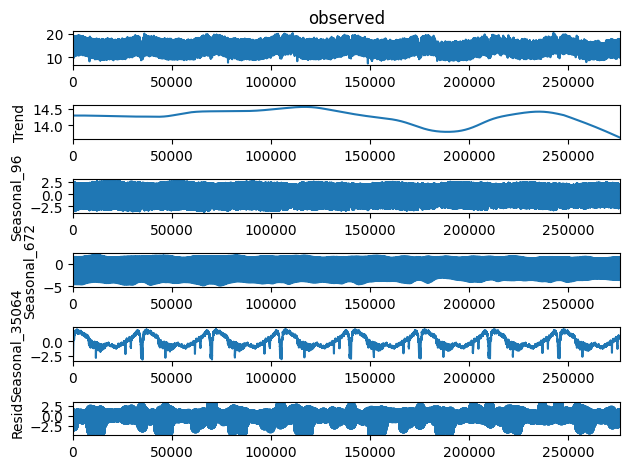

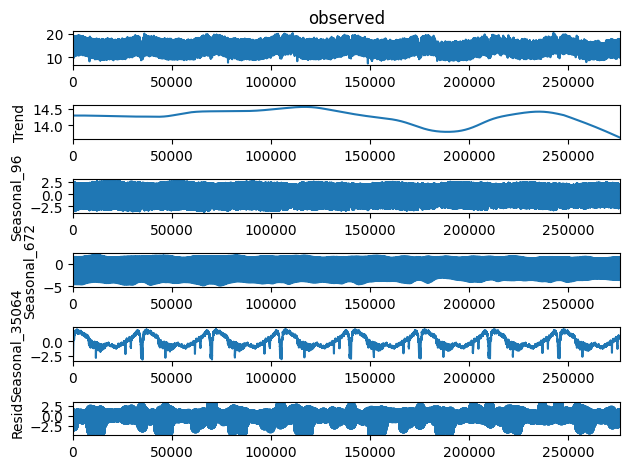

In [23]:
with open('mstl_v2.pkl', 'rb') as f:
    # unpickle
    resms2 = pickle.load(f)
seasonal2 = resms2.seasonal # contains 3 seasonal components
trend2 = resms2.trend
residual2 = resms2.resid
resms2.plot()
#why double plot? 

In [23]:
plt.plot(ti2/365.25,trend,'-',ms=1,color='blue',label='7.5 yr trend') 
plt.plot(ti2b/365.25,trend2,'-',ms=1,color='red',label='8 yr trend') 
plt.legend(loc="best")
plt.xlabel("years")
plt.title("MTSL over 7.5 years")
plt.ylabel("total power [MW]")
#plt.xlim(2735,2738)

NameError: name 'ti2' is not defined

There is a different in trend when recent is included. Still does not matter, really because that is just a rather constant offset which can be easily modelled with little data. 

Looks like the is a clear effect of Ukraine invasion and likely also of covid, while besides he trend could be rather small. Some temperate data to compare would be also nice. 

In [24]:
plt.plot(ti2b/365.25,seasonal2.iloc[:,2],'-',ms=1,color='red',label='8 yr year') 
plt.plot(ti2/365.25,seasonal.iloc[:,2],'-',ms=1,color='blue',label='7.5 yr year') 
plt.legend(loc="best")
plt.xlabel("years")
plt.title("MTSL")
plt.ylabel("power [MW]")
plt.xlim(7,8)
print(f"{round(np.std(seasonal.iloc[:,2]-seasonal2.iloc[:trend.shape[0],2])/np.mean(power)*100,2)} % deviation for week model")
print(f"{round(np.std(seasonal.iloc[245448:,2]-seasonal2.iloc[245448:trend.shape[0],2])/np.mean(power)*100,2)} % deviation for week model in 8th year")

NameError: name 'ti2b' is not defined

In [25]:
plt.plot(ti2b/365.25,seasonal2.iloc[:,1],'-',ms=1,color='red',label='8 yr week') 
plt.plot(ti2/365.25,seasonal.iloc[:,1],'-',ms=1,color='blue',label='7.5 yr week') 
plt.legend(loc="best")
plt.xlabel("years")
plt.title("MTSL")
plt.ylabel("power [MW]")
plt.xlim(7,8)
print(f"{round(np.std(seasonal.iloc[:,1]-seasonal2.iloc[:trend.shape[0],1])/np.mean(power)*100,2)} % deviation for week model")
print(f"{round(np.std(seasonal.iloc[245448:,1]-seasonal2.iloc[245448:trend.shape[0],1])/np.mean(power)*100,2)} % deviation for week model in 8th year")

NameError: name 'ti2b' is not defined

In [26]:
plt.plot(ti2b/365.25,seasonal2.iloc[:,0],'-',ms=1,color='red',label='8 yr day') 
plt.plot(ti2/365.25,seasonal.iloc[:,0],'-',ms=1,color='blue',label='7.5 yr day') 
plt.legend(loc="best")
plt.xlabel("years")
plt.title("MTSL")
plt.ylabel("power [MW]")
plt.xlim(7,8)
print(f"{round(np.std(seasonal.iloc[:,0]-seasonal2.iloc[:trend.shape[0],0])/np.mean(power)*100,2)} % deviation for day model")
print(f"{round(np.std(seasonal.iloc[245448:,0]-seasonal2.iloc[245448:trend.shape[0],0])/np.mean(power)*100,2)} % deviation for day model in 8th year")

NameError: name 'ti2b' is not defined

Deviation of year, week and day models are small. Thus using the full for training MTSL should have minor impact on double data use. The day resiua is very small which mean that the impact on the prediction below which uses only the last 1-2 day is very small.  

Still would be better when it could predict future. Also since that is needed for application on real world data. 

In [27]:
print(f"train data has {round(np.std(residual)/np.mean(power_train)*100,2)} % scatter")
print(f"full data has {round(np.std(residual2)/np.mean(power)*100,2)} % scatter")


NameError: name 'power_train' is not defined

In [24]:
residua=residual2.to_numpy()

In [36]:
resf=np.loadtxt('xgb_1day_8yr_mtsl_residua_v1.txt')
steps = 13250
for i in range(95,96):
    print(i)
    res3=series_to_supervised(residua,96,1,i)
    res3=pd.DataFrame(res3)
    dataa3_train = res3.iloc[:-steps,:]
    dataa3_test  = res3.iloc[-steps:,:]
    x3_train=dataa3_train.iloc[:,0:96]
    x3_test=dataa3_test.iloc[:,0:96]
    y3_train=dataa3_train.iloc[:,96]
    y3_test=dataa3_test.iloc[:,96]
    resf[0,i]=15*(i+1)
    xmodel3=XGBRegressor()
    xmodel3.fit(x3_train,y3_train)
    pred3=xmodel3.predict(x3_test)
    diff6=y3_test.shift(periods=i+1)
    resf[2,i]=np.std(pred3-y3_test)
    resf[1,i]=np.std(diff6-y3_test)
    resf[3,i]=np.mean(y3_test)
    np.savetxt('xgb_1day_8yr_mtsl_residua_v1b.txt',resf)  #written out was 1.txt

64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95


In [ ]:
resf2=np.loadtxt("xgb_1week_v1b.txt")
resf=np.loadtxt("xgb_1day_v1.txt")
resf8=np.loadtxt('xgb_1day_8yr_v1.txt')
resfm=np.loadtxt('xgb_1day_8yr_mtsl_residua_v1.txt')
residual2_train = residual2.iloc[:-steps]
residual2_test  = residual2.iloc[-steps:]

In [48]:
print("standard deviation of residua after MTSL")
print(f"train: {round(100*np.std(residual2_train)/np.mean(power_train),2)}% test: {round(100*np.std(residual2_test)/np.mean(power_test),2)}%")

standard deviation of residua after MTSL
train: 3.76% test: 2.86%


Is smaller in test than train part, does not has a meaning here, since bith are used MTSAL. Smaller error could have several reasons, one possiblity is that it the second half of the year there are only certain date holidays. 

[0.26816652 0.25477029]


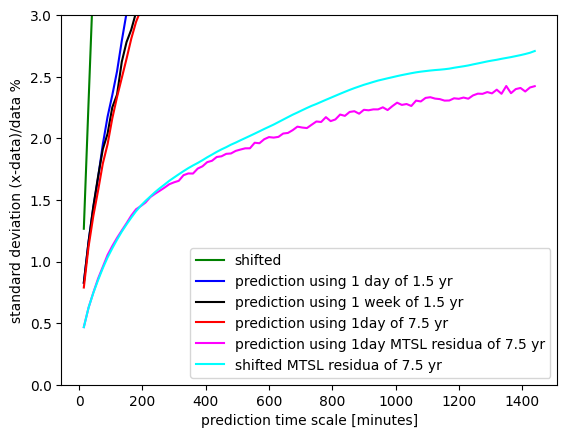

In [39]:
#add overall residua scatter
plt.plot(resf[0],100*resf[1]/resf[3],'-',ms=1,color='green',label='shifted') 
plt.plot(resf[0],100*resf[2]/resf[3],'-',ms=1,color='blue',label='prediction using 1 day of 1.5 yr') 
plt.plot(resf[0],100*resf2[2]/resf[3],'-',ms=1,color='black',label='prediction using 1 week of 1.5 yr') 
plt.plot(resf8[0],100*resf8[2]/resf8[3],'-',ms=1,color='red',label='prediction using 1day of 7.5 yr')
plt.plot(resfm[0],100*resfm[2]/resf[3],'-',ms=1,color='magenta',label='prediction using 1day MTSL residua of 7.5 yr')
plt.plot(resfm[0],100*resfm[1]/resf[3],'-',ms=1,color='cyan',label='shifted MTSL residua of 7.5 yr')
plt.plot(resfm[0],100*np.std(residual2_test)/np.mean(power_test)]+resfm[0]*0,'-',ms=1,color='gray',label='just MTSL of 8 yr')
plt.legend(loc="best")
plt.xlabel("prediction time scale [minutes]")
#plt.title("7 day random forest")
plt.ylabel("standard deviation (x-data)/data %")
#plt.xlim(0,1400)
plt.ylim(0,3)
#print(resfm[1:3,35])

Text(0, 0.5, 'standard deviation (x-data)/data %')

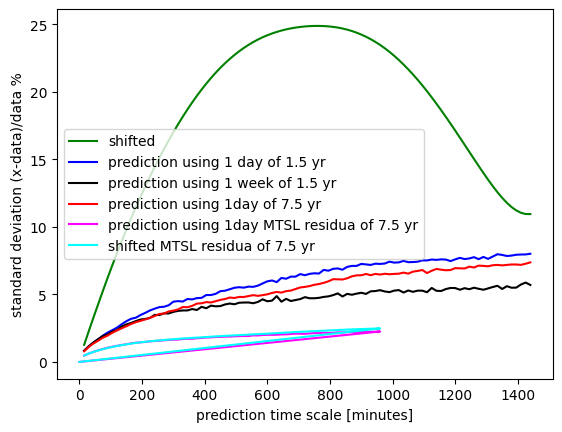

In [35]:
plt.plot(resf[0],100*resf[1]/resf[3],'-',ms=1,color='green',label='shifted') 
plt.plot(resf[0],100*resf[2]/resf[3],'-',ms=1,color='blue',label='prediction using 1 day of 1.5 yr') 
plt.plot(resf[0],100*resf2[2]/resf[3],'-',ms=1,color='black',label='prediction using 1 week of 1.5 yr') 
plt.plot(resf8[0],100*resf8[2]/resf8[3],'-',ms=1,color='red',label='prediction using 1day of 7.5 yr')
plt.plot(resfm[0],100*resfm[2]/resf[3],'-',ms=1,color='magenta',label='prediction using 1day MTSL residua of 7.5 yr')
plt.plot(resfm[0],100*resfm[1]/resf[3],'-',ms=1,color='cyan',label='shifted MTSL residua of 7.5 yr')

plt.legend(loc="best")
plt.xlabel("prediction time scale [minutes]")
#plt.title("7 day random forest")
plt.ylabel("standard deviation (x-data)/data %")
#plt.xlim(0,900)
#plt.ylim(0,4)


XGBosst and just shifting perform rather similar for smaller scale prediction now. Sometimes just shifting is better. Since xgboost should in the worst case have the same performance it means that there is overfitting.

From about 5 hours xgboost is better but also not by a lot. Both are clearer better than the other fits on all time scales. The improvement is smallest on the smallest time scales where the not (well) accounting for the periodicity in the other models has no large impact. 

In [2]:
#temperature first Grossenkneten northern Germany
thisyear=pd.read_csv('produkt_tu_stunde_20210606_20221207_00044.txt',delimiter=';')
older=pd.read_csv('produkt_tu_stunde_20070401_20211231_00044.txt',delimiter=';')
#73 Aldersbach-Kriestorf Bayern
thisyear73=pd.read_csv('produkt_tu_stunde_20210606_20221207_00073.txt',delimiter=';')
older73=pd.read_csv('produkt_tu_stunde_20070401_20211231_00073.txt',delimiter=';')
#78 Alfhausen                                Niedersachsen 
thisyear78=pd.read_csv('produkt_tu_stunde_20210606_20221207_00078.txt',delimiter=';')
older78=pd.read_csv('produkt_tu_stunde_20041101_20211231_00078.txt',delimiter=';')
#91 Alsfeld-Eifa                             Hessen
older91=pd.read_csv('produkt_tu_stunde_20040901_20211231_00091.txt',delimiter=';')
thisyear91=pd.read_csv('produkt_tu_stunde_20210607_20221208_00091.txt',delimiter=';')
#102 Leuchtturm Alte Weser                    Niedersachsen        
older102=pd.read_csv('produkt_tu_stunde_20020101_20211231_00102.txt',delimiter=';')
thisyear102=pd.read_csv('produkt_tu_stunde_20210607_20221208_00102.txt',delimiter=';')

In [3]:
#function which  create date time,create nan combines the two data sets avoiding duplicates 
#input is old and new data of the same station 
def preprocess_weather_station(old,new):
    #cretae date time column
    new['date_time']=pd.to_datetime(new['MESS_DATUM'], format='%Y%m%d%H')
    old['date_time']=pd.to_datetime(old['MESS_DATUM'], format='%Y%m%d%H')
    #replace -999 with NaN
    new.replace(-999.,np.NaN,inplace=True)
    old.replace(-999.,np.NaN,inplace=True)
    #get dates to see whether there is date overlap
    newest_in_old=max(old['date_time'])
    print(f"newest date in old is {newest_in_old}")
    print(f"oldest date in new is {min(new['date_time'])}")
    #exclude overlap dates form new
    new=new[new.date_time>newest_in_old]
    #set index for concat on it
    old=old.set_index('date_time')
    new=new.set_index('date_time')
    #combine with concat
    combined=pd.concat([old,new])
    #make index to normal column for normal excess to it
    combined=combined.reset_index()
    return combined

In [4]:
station1=preprocess_weather_station(older,thisyear)
station2=preprocess_weather_station(older73,thisyear73)
station3=preprocess_weather_station(older78,thisyear78)
station4=preprocess_weather_station(older91,thisyear91)
station5=preprocess_weather_station(older102,thisyear102)

newest date in old is 2021-12-31 23:00:00
oldest date in new is 2021-06-06 00:00:00
newest date in old is 2021-12-31 23:00:00
oldest date in new is 2021-06-06 00:00:00
newest date in old is 2021-12-31 23:00:00
oldest date in new is 2021-06-06 00:00:00
newest date in old is 2021-12-31 23:00:00
oldest date in new is 2021-06-07 00:00:00
newest date in old is 2021-12-31 23:00:00
oldest date in new is 2021-06-07 00:00:00


In [5]:
print(station1.date_time)

0        2007-04-01 00:00:00
1        2007-04-01 01:00:00
2        2007-04-01 02:00:00
3        2007-04-01 03:00:00
4        2007-04-01 04:00:00
                 ...        
136726   2022-12-07 19:00:00
136727   2022-12-07 20:00:00
136728   2022-12-07 21:00:00
136729   2022-12-07 22:00:00
136730   2022-12-07 23:00:00
Name: date_time, Length: 136731, dtype: datetime64[ns]


(-40.0, 40.0)

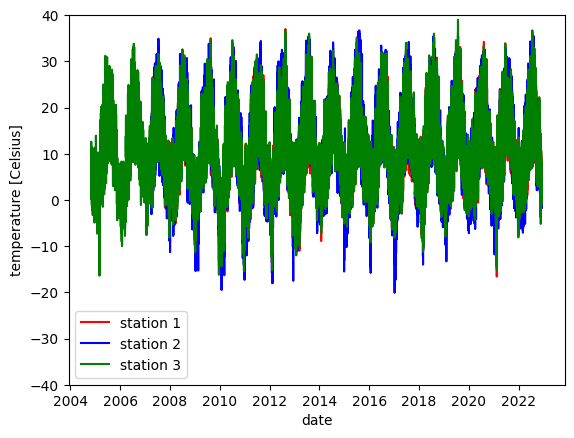

In [6]:
plt.plot(station1['date_time'],station1['TT_TU'],'-',ms=1,color='red',label='station 1') 
plt.plot(station2['date_time'],station2['TT_TU'],'-',ms=1,color='blue',label='station 2') 
plt.plot(station3['date_time'],station3['TT_TU'],'-',ms=1,color='green',label='station 3') 
plt.legend(loc="best")
plt.xlabel("date")
plt.ylabel("temperature [Celsius]")
plt.ylim(-40,40)
#plt.xlim(datetime(2020, 12, 1),datetime(2022, 12, 14))
#plt.yscale('log')



In [7]:
print(station1.shape)
print(station2.shape)
print(station3.shape)

(136731, 7)
(137199, 7)
(158661, 7)


In [8]:
#combine station
#up 2 or more stations
def comb_stations(station_list):
    #create summaryframe with largest and smallest times in frames
    #first dummy date
    time=pd.DataFrame(datetime(2020, 12, 1), index=np.arange(0,len(station_list),1),columns=['min_time', 'max_time'])
    for i in range(len(station_list)):
        df=station_list[i]
        time.iat[i,0]=min(df.date_time)
        time.iat[i,1]=max(df.date_time)
    print(time) 
    #median does not work on date directly
    medmin=time['min_time'].quantile(0.5, interpolation="midpoint") 
    print(medmin)
    medmax=time['max_time'].quantile(0.5, interpolation="midpoint") 
    print(medmax)
    #create station name for columns
    liststat=[]
    for i in range(len(station_list)):
        liststat.append('station'+str(i))
    liststat.append('date_time')    
    print(liststat) 
    #create data frame with data (and dummy (that is a df)
    listt=['dummy']
    listt.append(liststat[len(liststat)-1])
    print(listt)
    #get date difefrence
    dif=(medmax-medmin)
    #length in hours, +1 because first is not included
    running_hour=int(dif.total_seconds()/3600+1)
    print(running_hour)
    #create combined frame with date range median of min and max_time as limits
    combined=pd.DataFrame(np.nan,index=np.arange(0,running_hour,1),columns=listt)
    for i in range(combined.shape[0]):
        combined.iloc[i,combined.shape[1]-1]=medmin+timedelta(hours=i)
    combined['date_time']=pd.to_datetime(combined['date_time'])
    #combined=combined.set_index('date_time')
    print(combined.dtypes)
    for i in range(len(station_list)):
        print(f"merge station {i}")
        df=station_list[i]
        #drop most columns
        df=df.drop('STATIONS_ID',axis=1)
        df=df.drop('MESS_DATUM',axis=1)
        df=df.drop('QN_9',axis=1)
        df=df.drop('RF_TU',axis=1)
        df=df.drop('eor',axis=1)
        print(liststat[i])
        #rename tmeperature to avoid name collisons
        df=df.rename({'TT_TU':'t_'+liststat[i]}, axis='columns')
        #merge
        combined=pd.merge(combined,df,'left')
    #drop dummy 
    combined=combined.drop('dummy',axis=1)     
    return combined

In [9]:
station_list1=[station1,station2,station3,station4,station5]
temp_combined=comb_stations(station_list1)

    min_time            max_time
0 2007-04-01 2022-12-07 23:00:00
1 2007-04-01 2022-12-07 23:00:00
2 2004-11-01 2022-12-07 23:00:00
3 2004-09-01 2022-12-08 23:00:00
4 2002-01-01 2022-12-08 23:00:00
2004-11-01 00:00:00
2022-12-07 23:00:00
['station0', 'station1', 'station2', 'station3', 'station4', 'date_time']
['dummy', 'date_time']
158664
dummy               float64
date_time    datetime64[ns]
dtype: object
merge station 0
station0
merge station 1
station1
merge station 2
station2
merge station 3
station3
merge station 4
station4


In [10]:
print(temp_combined)

                 date_time  t_station0  t_station1  t_station2  t_station3  \
0      2004-11-01 00:00:00         NaN         NaN         3.3         6.8   
1      2004-11-01 01:00:00         NaN         NaN         5.1         7.8   
2      2004-11-01 02:00:00         NaN         NaN         5.9         6.7   
3      2004-11-01 03:00:00         NaN         NaN         6.1         8.3   
4      2004-11-01 04:00:00         NaN         NaN         6.1         8.7   
...                    ...         ...         ...         ...         ...   
158659 2022-12-07 19:00:00         1.9         2.4         3.0         2.5   
158660 2022-12-07 20:00:00         2.2         2.3         2.6         2.4   
158661 2022-12-07 21:00:00         2.4         1.8         2.7         2.3   
158662 2022-12-07 22:00:00         2.3         1.8         2.7         2.2   
158663 2022-12-07 23:00:00         2.2         1.6         2.5         2.3   

        t_station4  
0             10.2  
1             10.2  


In [51]:
month=temp_combined.groupby(pd.PeriodIndex(temp_combined['date_time'], freq="M")).mean()

/tmp/ipykernel_8525/414651993.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  month=temp_combined.groupby(pd.PeriodIndex(temp_combined['date_time'], freq="M")).mean()


In [52]:
print(month)
month=month.reset_index()

           t_station0  t_station1  t_station2  t_station3  t_station4
date_time                                                            
2004-11           NaN         NaN    4.980139    3.769861    7.269382
2004-12           NaN         NaN    2.464113   -0.137097    4.383401
2005-01           NaN         NaN    3.780081    1.849529    5.082225
2005-02           NaN         NaN    0.886458   -1.278274    2.128251
2005-03           NaN         NaN    4.691935    4.199731    4.254184
...               ...         ...         ...         ...         ...
2022-08     20.026657   20.217204   20.061828   19.853629   19.564189
2022-09     13.908889   13.596647   13.851250   13.002222   15.342142
2022-10     12.889651   12.018683   12.359812   11.897581   13.773748
2022-11      7.433611    5.552222    7.577917    6.616944    8.389548
2022-12      2.348810    1.917262    2.182143    1.129167    4.238095

[218 rows x 5 columns]


Text(0, 0.5, 'mean temperature [Celsius]')

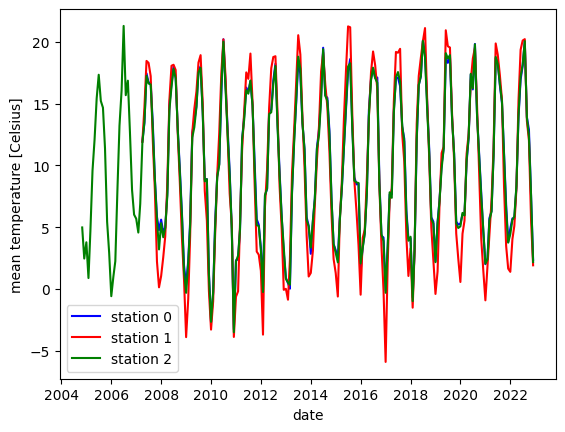

In [53]:
#create new date
month['date'] =datetime(2004, 11, 1)
month['month'] =0
for i in range(month.shape[0]):
    #create year month
    y=int(2004+(i+10)/12)
    m=(i+10)%12+1  
    #pass to datetime
    month.iloc[i,month.shape[1]-2]=datetime(y, m, 1)
    #month column for group by 
    month.iloc[i,month.shape[1]-1]=m
#plot
plt.plot(month.date,month.t_station0,'-',ms=1,color='blue',label='station 0') 
plt.plot(month.date,month.t_station1,'-',ms=1,color='red',label='station 1') 
plt.plot(month.date,month.t_station2,'-',ms=1,color='green',label='station 2') 
plt.legend(loc="best")
plt.xlabel("date")
plt.ylabel("mean temperature [Celsius]")
#plt.ylim(-40,40)

In [54]:
#mean per month
mean0=month.groupby('month').mean(numeric_only=True)
mean0=mean0.reset_index()
#rename to avoid name collisions collisions
mean0.rename({'t_station0':'mean_t_station0'}, axis='columns',inplace=True)
mean0.rename({'t_station1':'mean_t_station1'}, axis='columns',inplace=True)
mean0.rename({'t_station2':'mean_t_station2'}, axis='columns',inplace=True)
mean0.rename({'t_station3':'mean_t_station3'}, axis='columns',inplace=True)
mean0.rename({'t_station4':'mean_t_station4'}, axis='columns',inplace=True)

In [55]:
print(mean0)

    month  mean_t_station0  mean_t_station1  mean_t_station2  mean_t_station3  \
0       1         2.377834        -0.341919         2.411819         0.997547   
1       2         2.895358         1.017786         2.702574         1.420276   
2       3         5.393762         5.070511         5.232109         4.443204   
3       4         9.462412         9.970228         9.338426         8.853804   
4       5        13.150386        13.931572        12.950209        12.567832   
5       6        16.483594        18.113341        16.430784        16.280342   
6       7        17.926809        19.213981        18.111141        18.087418   
7       8        17.682647        18.810247        17.398604        17.320550   
8       9        14.132083        14.117635        14.168858        13.601134   
9      10        10.518607         9.285077        10.457273         9.596386   
10     11         6.412945         4.489332         6.258253         5.120760   
11     12         3.742136  

Text(0, 0.5, 'mean temperature [Celsius]')

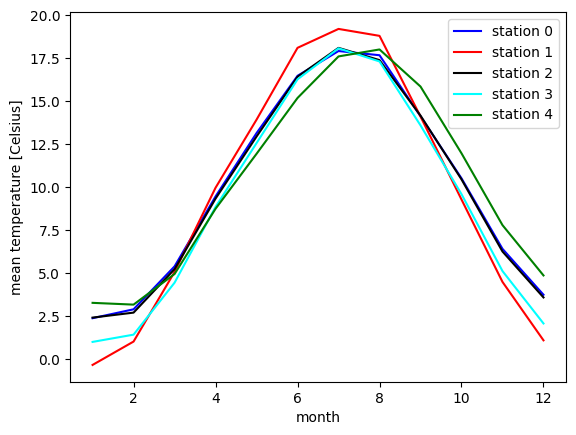

In [56]:
plt.plot(mean0.month,mean0.mean_t_station0,'-',ms=1,color='blue',label='station 0') 
plt.plot(mean0.month,mean0.mean_t_station1,'-',ms=1,color='red',label='station 1') 
plt.plot(mean0.month,mean0.mean_t_station2,'-',ms=1,color='black',label='station 2') 
plt.plot(mean0.month,mean0.mean_t_station3,'-',ms=1,color='cyan',label='station 3') 
plt.plot(mean0.month,mean0.mean_t_station4,'-',ms=1,color='green',label='station 4') 
plt.legend(loc="best")
plt.xlabel("month")
plt.ylabel("mean temperature [Celsius]")

In [108]:
#combine the mean in it 
combined_t=pd.merge(month,mean0,'left')
print(combined_t)
#and then subtract it 
combined_t['delta_station0']=combined_t.t_station0-combined_t.mean_t_station0
combined_t['delta_station1']=combined_t.t_station1-combined_t.mean_t_station1
combined_t['delta_station2']=combined_t.t_station2-combined_t.mean_t_station2
combined_t['delta_station3']=combined_t.t_station3-combined_t.mean_t_station3
combined_t['delta_station4']=combined_t.t_station4-combined_t.mean_t_station4

    date_time  t_station0  t_station1  t_station2  t_station3  t_station4  \
0     2004-11         NaN         NaN    4.980139    3.769861    7.269382   
1     2004-12         NaN         NaN    2.464113   -0.137097    4.383401   
2     2005-01         NaN         NaN    3.780081    1.849529    5.082225   
3     2005-02         NaN         NaN    0.886458   -1.278274    2.128251   
4     2005-03         NaN         NaN    4.691935    4.199731    4.254184   
..        ...         ...         ...         ...         ...         ...   
213   2022-08   20.026657   20.217204   20.061828   19.853629   19.564189   
214   2022-09   13.908889   13.596647   13.851250   13.002222   15.342142   
215   2022-10   12.889651   12.018683   12.359812   11.897581   13.773748   
216   2022-11    7.433611    5.552222    7.577917    6.616944    8.389548   
217   2022-12    2.348810    1.917262    2.182143    1.129167    4.238095   

          date  month  mean_t_station0  mean_t_station1  mean_t_station2  \

Text(0, 0.5, 'mean temperature deviation from month average [Celsius]')

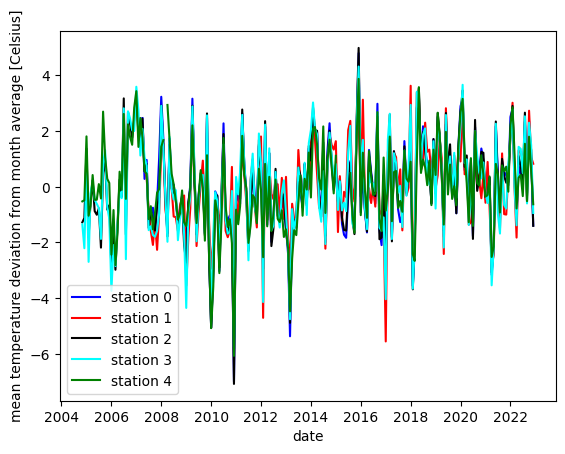

In [109]:
plt.plot(combined_t.date,combined_t.delta_station0,'-',ms=1,color='blue',label='station 0') 
plt.plot(combined_t.date,combined_t.delta_station1,'-',ms=1,color='red',label='station 1') 
plt.plot(combined_t.date,combined_t.delta_station2,'-',ms=1,color='black',label='station 2') 
plt.plot(combined_t.date,combined_t.delta_station3,'-',ms=1,color='cyan',label='station 3') 
plt.plot(combined_t.date,combined_t.delta_station4,'-',ms=1,color='green',label='station 4') 
plt.legend(loc="best")
plt.xlabel("date")
plt.ylabel("mean temperature deviation from month average [Celsius]")

In [113]:
#better a function for comparision
month_power=comb.groupby(pd.PeriodIndex(comb['date_time'], freq="M")).mean(numeric_only=True)

In [114]:
print(month_power)

           total_power  residual_power  pump_storage
date_time                                           
2015-01      15.169039       11.841439    217.005040
2015-02      15.660645       13.235263    196.986639
2015-03      14.916601       11.625043    215.127205
2015-04      13.903434       10.626253    204.529282
2015-05      13.204740        9.953929    199.899530
...                ...             ...           ...
2022-07      12.945088        8.184772    174.863176
2022-08      12.719948        8.754003    204.147261
2022-09      13.716975        9.250654    221.689760
2022-10      13.420340        8.545219    198.423787
2022-11      13.909362        7.737116    194.726580

[95 rows x 3 columns]


Text(0, 0.5, 'mean power')

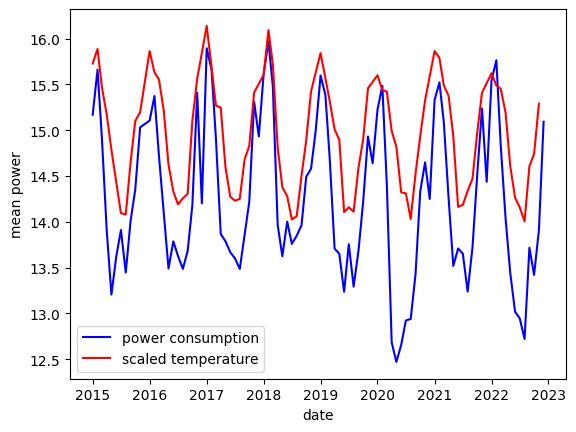

In [115]:
month_power=month_power.reset_index()
month_power['date'] =datetime(2015, 1, 1)
month_power['month'] =0

for i in range(month_power.shape[0]):
    #create year month
    y=int(2015+(i+1)/12)
    m=(i)%12+1  
    #pass to datetime
    month_power.iloc[i,month_power.shape[1]-2]=datetime(y, m, 1)
    #month column for group by 
    month_power.iloc[i,month_power.shape[1]-1]=m
#plot
month_power=month_power.sort_values(by=['date'])
combined_all=pd.merge(combined_t,month_power,'inner')
combined_all['avg_temp'] = combined_all[['t_station0', 't_station1','t_station2','t_station3', 't_station4',]].mean(axis=1)
combined_all['avg_delta_temp'] = combined_all[['delta_station0', 'delta_station1','delta_station2','delta_station3', 'delta_station4',]].mean(axis=1)

plt.plot(month_power.date,month_power.total_power,'-',ms=1,color='blue',label='power consumption')  
plt.plot(combined_all.date,-combined_all.avg_temp/10+16,'-',ms=1,color='red',label='scaled temperature') 
plt.legend(loc="best")
plt.xlabel("date")
plt.ylabel("mean power")

Text(0, 0.5, 'mean power')

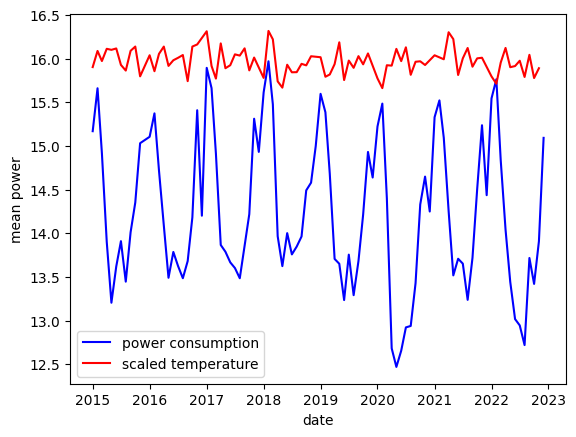

Index(['date_time', 't_station0', 't_station1', 't_station2', 't_station3',
       't_station4', 'date', 'month', 'mean_t_station0', 'mean_t_station1',
       'mean_t_station2', 'mean_t_station3', 'mean_t_station4',
       'delta_station0', 'delta_station1', 'delta_station2', 'delta_station3',
       'delta_station4', 'total_power', 'residual_power', 'pump_storage',
       'avg_temp', 'avg_delta_temp'],
      dtype='object')


Text(0, 0.5, 'mean power')

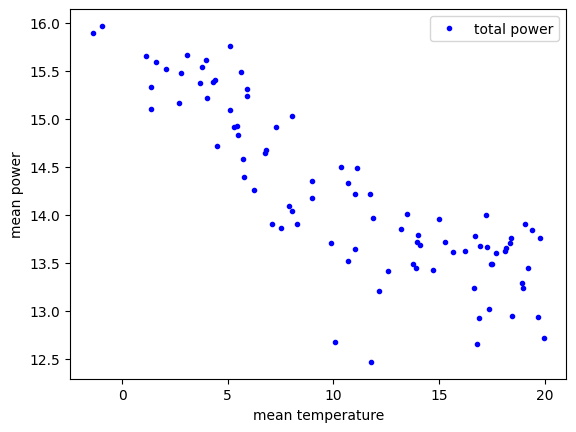

In [117]:
print(combined_all.columns)

plt.plot(combined_all.avg_temp,combined_all.total_power,'o',ms=3,color='blue',label='total power')  
plt.legend(loc="best")
plt.xlabel("mean temperature")
plt.ylabel("mean power")

In [122]:
mean0power=month_power.groupby('month').mean(numeric_only=True)
mean0power=mean0power.reset_index()
#rename to avoid name collisions collisions
mean0power.rename({'total_power':'mean_total_power'}, axis='columns',inplace=True)
mean0power.rename({'residual_power':'mean_residual_power'}, axis='columns',inplace=True)
mean0power.rename({'pump_storage':'mean_pump_storage'}, axis='columns',inplace=True)
combined_p=pd.merge(month_power,mean0power,'left')
#and then subtract it 
combined_p['delta_total_power']=combined_p.total_power-combined_p.mean_total_power
combined_p['delta_residual_power_']=combined_p.residual_power-combined_p.mean_residual_power
combined_p['delta_pump_storage']=combined_p.pump_storage-combined_p.mean_pump_storage

Text(0, 0.5, 'mean deviation from month average')

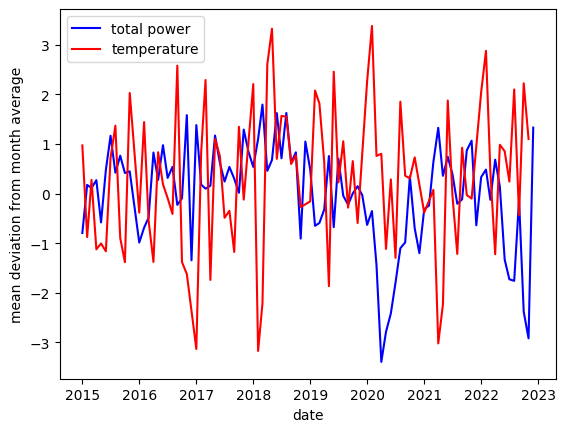

In [127]:
plt.plot(combined_p.date,combined_p.delta_total_power*3,'-',ms=1,color='blue',label='power consumption') 
plt.plot(combined_all.date,combined_all.avg_delta_temp,'-',ms=1,color='red',label='temperature') 
plt.legend(loc="best")
plt.xlabel("date")
plt.ylabel("mean deviation from month average")

(18262.0, 19327.0)

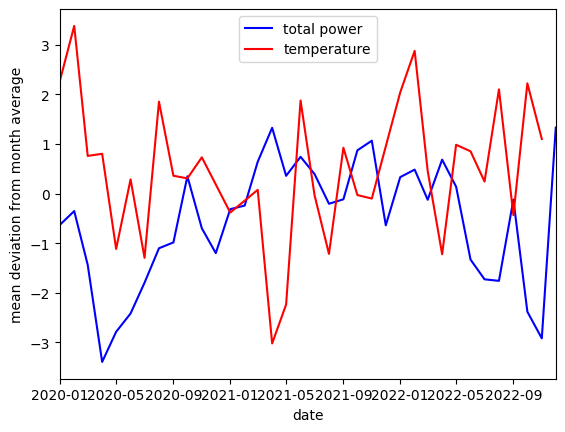

In [149]:
plt.plot(combined_p.date,combined_p.delta_total_power*3,'-',ms=1,color='blue',label='total power') 
plt.plot(combined_all.date,combined_all.avg_delta_temp,'-',ms=1,color='red',label='temperature') 
plt.legend(loc="best")
plt.xlabel("date")
plt.ylabel("mean deviation from month average")
plt.xlim(datetime(2020, 1, 1),datetime(2022, 12, 1))

The clearest dip in power consumption is in 2020, likely because covid economy crisis. Secondly, there is likely a dip in 2022 likely because higher natural gas prices. 

In [135]:
#combining also delta t/p 
combined_all2=pd.merge(combined_t,combined_p,'inner')
print(combined_all2.columns)

Index(['date_time', 't_station0', 't_station1', 't_station2', 't_station3',
       't_station4', 'date', 'month', 'mean_t_station0', 'mean_t_station1',
       'mean_t_station2', 'mean_t_station3', 'mean_t_station4',
       'delta_station0', 'delta_station1', 'delta_station2', 'delta_station3',
       'delta_station4', 'total_power', 'residual_power', 'pump_storage',
       'mean_total_power', 'mean_residual_power', 'mean_pump_storage',
       'delta_total_power', 'delta_residual_power_', 'delta_pump_storage'],
      dtype='object')


Text(0, 0.5, 'delta power')

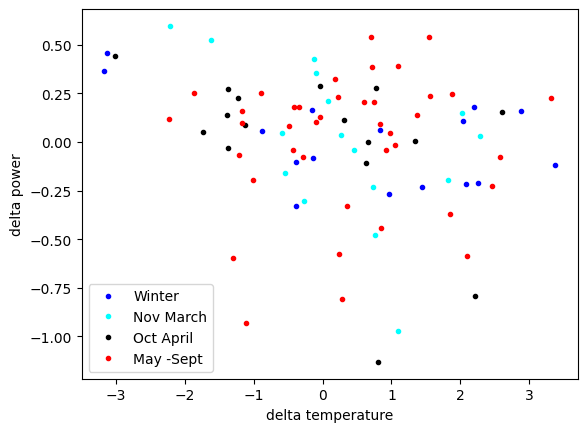

In [148]:
combined_all2['avg_temp'] = combined_all2[['t_station0', 't_station1','t_station2','t_station3', 't_station4',]].mean(axis=1)
combined_all2['avg_delta_temp'] = combined_all2[['delta_station0', 'delta_station1','delta_station2','delta_station3', 'delta_station4',]].mean(axis=1)

combined_all2_winter=combined_all2[(combined_all2.month==12) | (combined_all2.month<2.5)]
combined_all2_late1=combined_all2[(combined_all2.month==11) | (combined_all2.month==3)]
combined_all2_late2=combined_all2[(combined_all2.month==10) | (combined_all2.month==4)]
combined_all2_summer=combined_all2[(combined_all2.month<10) & (combined_all2.month>4)]
plt.plot(combined_all2_winter.avg_delta_temp,combined_all2_winter.delta_total_power,'o',ms=3,color='blue',label='Winter')  
plt.plot(combined_all2_late1.avg_delta_temp,combined_all2_late1.delta_total_power,'o',ms=3,color='cyan',label='Nov March')  
plt.plot(combined_all2_late2.avg_delta_temp,combined_all2_late2.delta_total_power,'o',ms=3,color='black',label='Oct April')  
plt.plot(combined_all2_summer.avg_delta_temp,combined_all2_summer.delta_total_power,'o',ms=3,color='red',label='May -Sept')  

plt.legend(loc="best")
plt.xlabel("delta temperature")
plt.ylabel("delta power")

There is some correlation with the delta temperature but the correlation is weak. That is expected given that the range of variation is small that way. 

Index(['date_time', 't_station0', 't_station1', 't_station2', 't_station3',
       't_station4', 'date', 'month', 'mean_t_station0', 'mean_t_station1',
       'mean_t_station2', 'mean_t_station3', 'mean_t_station4',
       'delta_station0', 'delta_station1', 'delta_station2', 'delta_station3',
       'delta_station4', 'total_power', 'residual_power', 'pump_storage',
       'mean_total_power', 'mean_residual_power', 'mean_pump_storage',
       'delta_total_power', 'delta_residual_power_', 'delta_pump_storage',
       'avg_temp', 'avg_delta_temp', 'mean_climate'],
      dtype='object')


Text(0, 0.5, 'mean power')

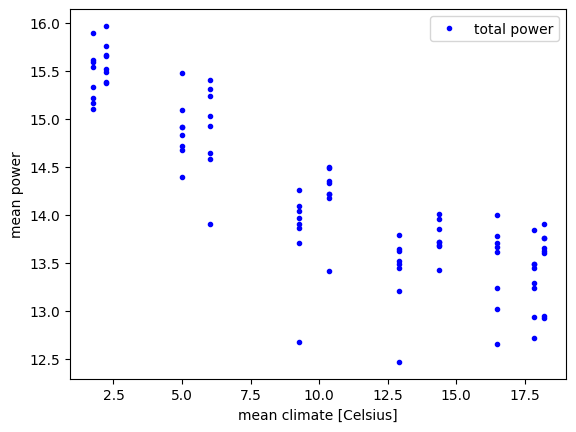

In [155]:
#tadd some chaine learning from climate maybe add n holidays price?
#should be the same as the mtsl xgboost at the end 
combined_all2['mean_climate'] = combined_all2[['mean_t_station0', 'mean_t_station1','mean_t_station2','mean_t_station3', 'mean_t_station4',]].mean(axis=1)
print(combined_all2.columns)
plt.plot(combined_all2.mean_climate,combined_all.total_power,'o',ms=3,color='blue',label='total power')  
plt.legend(loc="best")
plt.xlabel("mean climate [Celsius]")
plt.ylabel("mean power")

In [ ]:
#more improvement? add price (best short I assume), add holiday, weekday for medium term (but most should be already be included)
#try MTSL variants, understand MTSL forecast